# 6-Machine Learning (QBoost) with Quantum Annealing

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/OpenJij/OpenJijTutorial/blob/master/source/en/006-Machine_Learning_by_QA.ipynb)

In this section, we describe machine lerning (ML) as an example of an application of quantum annealing (QA) optimization.

In the first, we show clustering using PyQUBO and OpenJij.  
In the seconde, we execute an ensamble study called QBoost with PyQUBO and D-Wave sampler.

## Clustering

Clustering is the task of deviding given set of data into $n$ clusters ($n$ is our input). For the sake of simplicity, let us consider the number of cluster is 2 in this time.

### Importing the required libraries

We import scikit-learn library for ML.

In [1]:
# import libraries
import numpy as np
from matplotlib import pyplot as plt
from sklearn import cluster
import pandas as pd
from scipy.spatial import distance_matrix 
from pyqubo import Array, Constraint, Placeholder, solve_qubo
import openjij as oj
from sklearn.model_selection import train_test_split

### Make artificial data

In this case, let us generate linearly separable data in a two-dimensional plane artificially.

In [2]:
data = []
label = []
for i in range(100):
    # generate 0 to 1 random number
    p = np.random.uniform(0, 1)
    # set class 1 when certain condition are met, and -1 when it are not met
    cls =1 if p>0.5 else -1
    # create random numbers following a normal distribution
    data.append(np.random.normal(0, 0.5, 2) + np.array([cls, cls]))
    label.append(cls)
# formatted as a DataFrame
df1 = pd.DataFrame(data, columns=["x", "y"], index=range(len(data)))
df1["label"] = label

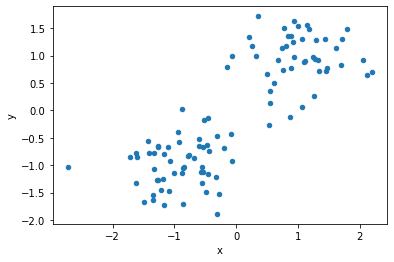

In [3]:
# visualize dataset
df1.plot(kind='scatter', x="x", y="y")
plt.show()

We demonstrate clustering by minimizing the following Hamiltonians.

$$
H = - \sum_{i, j} \frac{1}{2}d_{i,j} (1 - \sigma _i \sigma_j)
$$

Where $i, j$ is sample No., $d_{i, j}$ is a distance between $i$ and $j$, $\sigma_i=\{-1,1\}$ is spin variable that indicates whether $i$ belong to one of the two clusters.

Each term of this Hamiltonian sum behaves as follows.

- 0 for $\sigma_i  = \sigma_j $
- $d_{i,j}$ for $\sigma_i  \neq \sigma_j $  

Note that minus of R.H.S., Hamiltonian means the problem is "Choosing pairs of $\{\sigma _1, \sigma _2 \ldots \}$ that maximizes the distance between the samples of different classes".

### Clustering with PyQUBO

At first, we formulate the Hamiltonian in PyQUBO. Second, we execute simulated annealing (SA) with `solve_qubo`.

In [6]:
def clustering_pyqubo(df):
    # set distance matrix
    d_ij = distance_matrix(df, df)
    # set spin variables
    spin = Array.create("spin", shape= len(df), vartype="SPIN")
    # set the total Hamiltonian
    H = - 0.5* sum(
        [d_ij[i,j]* (1 - spin[i]* spin[j]) for i in range(len(df)) for j in range(len(df))]
    )
    # compile
    model = H.compile()
    # convert to QUBO
    qubo, offset = model.to_qubo()
    # solve with SA
    raw_solution = solve_qubo(qubo, num_reads=10)
    # decode for easier analysis
    decoded_samples = model.decode_sample(raw_solution, vartype="SPIN")
    # extract label
    labels = [decoded_samples.array("spin", idx) for idx in range(len(df))]
    return labels

We execute and check a solution.

In [7]:
labels =clustering_pyqubo(df1[["x", "y"]])
print("label", labels)

label [1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0]


<ipython-input-6-79e62663b237>:15: DeprecationWarning: Call to deprecated function (or staticmethod) solve_qubo. (You should use simulated annealing sampler of dwave-neal directly.) -- Deprecated since version 0.4.0.
  raw_solution = solve_qubo(qubo, num_reads=10)


Let us visualize the result.

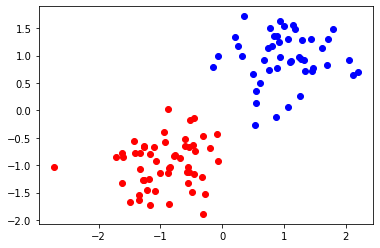

In [8]:
for idx, label in enumerate(labels):
    if label:
        plt.scatter(df1.loc[idx]["x"], df1.loc[idx]["y"], color="b")  
    else:
        plt.scatter(df1.loc[idx]["x"], df1.loc[idx]["y"], color="r")

### Clustering with OpenJij solver

Next, we introduce clustering with OpenJij solver and use PyQUBO to formulate QUBO.

In [9]:
def clustering_openjij(df):
    # set distance matrix
    d_ij = distance_matrix(df, df)
    # set spin variables
    spin = Array.create("spin", shape= len(df), vartype="SPIN")
    # set total Hamiltonian
    H = - 0.5* sum(
        [d_ij[i,j]* (1 - spin[i]* spin[j]) for i in range(len(df)) for j in range(len(df))]
    )
    # compile
    model = H.compile()
    # convert to QUBO
    qubo, offset = model.to_qubo()
    # set OpenJij SA sampler
    sampler = oj.SASampler(num_reads=10, num_sweeps=100)
    # solve with above sampler
    response = sampler.sample_qubo(qubo)
    # extract raw data
    raw_solution = dict(zip(response.indices, response.states[np.argmin(response.energies)]))
    # decode for easier analysis
    decoded_samples= model.decode_sample(raw_solution, vartype="SPIN")
    # extract labels
    labels = [int(decoded_samples.array("spin", idx) ) for idx  in range(len(df))]
    return labels,  sum(response.energies)

We execute and check a solution.

In [10]:
labels, energy =clustering_openjij(df1[["x", "y"]])
print("label", labels)
print("energy", energy)

label [1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0]
energy -139358.74510750096


And also we visualize the result.

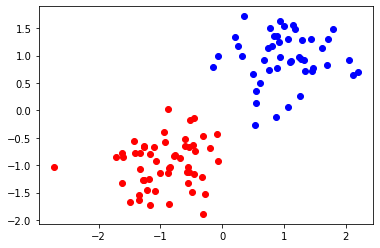

In [11]:
for idx, label in  enumerate(labels):
    if label:
        plt.scatter(df1.loc[idx]["x"], df1.loc[idx]["y"], color="b")  
    else:
        plt.scatter(df1.loc[idx]["x"], df1.loc[idx]["y"], color="r")

We can get a same figure as using PyQUBO SA.

## QBoost

QBoost is a one of the ensamble learning using QA. Ensamble learning involves preparing a number of weak predictors and combining the results of each of these predictors to obtain the final prediction result.

QBoost uses QA to optimize the best combination of learners for a given training data. We handle classification problem in this time.

We define that the set of $D$ training data are $\{\vec x^{(d)}\}(d=1, ..., D)$, corresponding label are $\{y^{(d)}\}(d=1, ..., D), y^{(d)}\in \{-1, 1\}$ and the (function) set of $N$ weak learner is $\{C_i\}(i=1, ..., N)$. For some data $\vec x^{(d)}$, $C_i(\vec x^{(d)})\in \{-1, 1\}$. 

Based on the definitions above, the classification labels are as follows.

$${\rm sgn}\left( \sum_{i=1}^{N} w_i C_i({\vec x}^{(d)})\right)$$

Where $w_i\in\{0, 1\} (i=1, ..., N)$, is a weight of each predictor (bool value to adopt or not adopt the predictor for the final prediction).QBoost optimizes the combination of $w_i$ so that prediction matches the training data while erasing the number of weak learners.

Hamiltonian in this problem is as follows.

$$H(\vec w) = \sum_{d=1}^{D} \left( \frac{1}{N}\sum_{i=1}^{N} w_i C_i(\vec x^{(d)})-y^{(d)} \right)^2 + \lambda \sum _i^N w_i$$

The first term represents the difference between weak classifier and the correct label. The second term represents a degree of the number of weak classifier to be employed in the final classifier. $\lambda$ is the regularization parameter that adjust how much the number of weak classifiers affects the total Hamiltonian.

We optimize this Hamiltonian by recognizing the first term as a cost (objective function) and the second term as a constraint.Minimizing with QA allows us to obtain a combination of weak classifiers that best fits the training data.

### Scripts

Let us try QBoost. We use the cancer identification dataset from scikit-learn for training data. For simplicity, we will only use two character types for training: "0" and "1".

In [12]:
# import libraries
import pandas as pd 
from scipy import stats 
from sklearn import datasets
from sklearn import metrics

In [13]:
# load data
cancerdata = datasets.load_breast_cancer()
# set the number of training data & test data
num_train = 450

In this time, we consider that feature of noise exists.

In [14]:
data_noisy = np.concatenate((cancerdata.data, np.random.rand(cancerdata.data.shape[0], 30)), axis=1)
print(data_noisy.shape)

(569, 60)


In [15]:
# convert from label {0, 1} to {-1, 1}
labels = (cancerdata.target-0.5) * 2

In [16]:
# divide dataset to training and test
X_train = data_noisy[:num_train, :]
X_test = data_noisy[num_train:, :]
y_train = labels[:num_train]
y_test = labels[num_train:]

In [17]:
# from the result of weak learnor
def aggre_mean(Y_list):
    return ((np.mean(Y_list, axis=0)>0)-0.5) * 2

### Set of Weak Learner

We make weak learner with scikit-learn. In this time, we choose decision stump. Desision stump is a single-layer decision tree. As it will be used as a weak classifier, the features to be used for segmentation are selected randomly (it's a good understanding that we execute single-layer of random forest).

In [18]:
# import required libraries
from sklearn.tree import DecisionTreeClassifier as DTC

# set the number of weak classifier
num_clf = 32
# set the number of ensembles to be taken out for one sample in bootstrap sampling
sample_train = 40
# set model
models = [DTC(splitter="random",max_depth=1) for i in range(num_clf)]
for model in models:
    # extract randomly
    train_idx = np.random.choice(np.arange(X_train.shape[0]), sample_train)
    # make decision tree with variables
    model.fit(X=X_train[train_idx], y=y_train[train_idx])
y_pred_list_train = []
for model in models:
    # execute prediction with model
    y_pred_list_train.append(model.predict(X_train))
y_pred_list_train = np.asanyarray(y_pred_list_train)
y_pred_train =np.sign(y_pred_list_train)

We look accuracy of all weak learner as the final classifier. Henceforth, we refer to this combination as baseline.

In [19]:
y_pred_list_test = []
for model in models:
    # execute with test data
    y_pred_list_test.append(model.predict(X_test))
    
y_pred_list_test = np.array(y_pred_list_test)
y_pred_test = np.sign(np.sum(y_pred_list_test,axis=0))
# compute score of prediction accuracy
acc_test_base = metrics.accuracy_score(y_true=y_test, y_pred=y_pred_test)
print(acc_test_base)

0.9663865546218487


In [20]:
# set class of QBoost
class QBoost():
    def __init__(self, y_train, ys_pred):
        self.num_clf = ys_pred.shape[0]
        # set binary variables
        self.Ws = Array.create("weight", shape = self.num_clf, vartype="BINARY")
        # set hyperparameter with PyQUBO Placeholder
        self.param_lamda = Placeholder("norm")
        # set combination of weak classifier Hamiltonian
        self.H_clf = sum( [ (1/self.num_clf * sum([W*C for W, C in zip(self.Ws, y_clf)])- y_true)**2 for y_true, y_clf in zip(y_train, ys_pred.T)
        ])
        # set normalization term as a constraint
        self.H_norm = Constraint(sum([W for W in self.Ws]), "norm")
        # set total Hamiltonian
        self.H = self.H_clf + self.H_norm * self.param_lamda
        # compile
        self.model = self.H.compile()
    # set function for converting to QUBO
    def to_qubo(self, norm_param=1):
        # set value of hyperparameter
        self.feed_dict = {'norm': norm_param}
        return self.model.to_qubo(feed_dict=self.feed_dict)

In [21]:
qboost = QBoost(y_train=y_train, ys_pred=y_pred_list_train)
# make QUBO with lambda=3
qubo = qboost.to_qubo(3)[0]

### Execute QBoost with D-Wave Sampler

In [20]:
# import required libraries
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

In [25]:
# set DwaveSampler with token yourself
dw = DWaveSampler(endpoint='https://cloud.dwavesys.com/sapi/', 
                  token='xxxx', 
                  solver='DW_2000Q_VFYC_6')
# embed on chimeragraph
sampler = EmbeddingComposite(dw)

SolverAuthenticationError: Token not accepted for that action.

In [26]:
# compute DWaveSampler
sampleset = sampler.sample_qubo(qubo, num_reads=100)

NameError: name 'sampler' is not defined

In [27]:
# check the result
print(sampleset)

NameError: name 'sampleset' is not defined

In [28]:
# decode each computation result with PyQUBO
decoded_solutions = []
brokens = []
energies =[]

decoded_sol = qboost.model.decode_dimod_response(sampleset, feed_dict=qboost.feed_dict)
for d_sol, broken, energy in decoded_sol:
    decoded_solutions.append(d_sol)
    brokens.append(broken)
    energies.append(energy)

NameError: name 'sampleset' is not defined

Let us check the accuracy in the training/validation data when using a combination of weak classifiers obtained by D-Wave.

In [29]:
accs_train_Dwaves = []
accs_test_Dwaves = []
for decoded_solution in decoded_solutions:
    idx_clf_DWave=[]
    for key, val in decoded_solution["weight"].items():
        if val == 1:
            idx_clf_DWave.append(int(key))
    y_pred_train_DWave = np.sign(np.sum(y_pred_list_train[idx_clf_DWave, :], axis=0))
    y_pred_test_DWave = np.sign(np.sum(y_pred_list_test[idx_clf_DWave, :], axis=0))
    acc_train_DWave = metrics.accuracy_score(y_true=y_train, y_pred=y_pred_train_DWave)
    acc_test_DWave= metrics.accuracy_score(y_true=y_test, y_pred=y_pred_test_DWave)
    accs_train_Dwaves.append(acc_train_DWave)
    accs_test_Dwaves.append(acc_test_DWave)

We make a graph with energy on the horizontal axis and accuracy on the vertical axis.

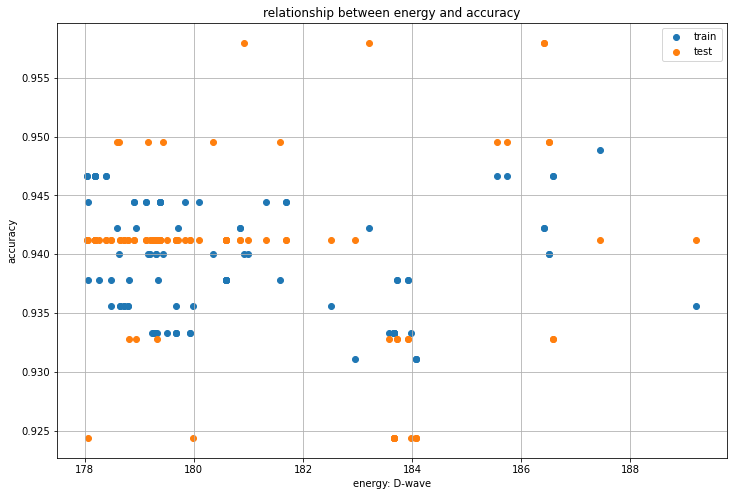

In [43]:
plt.figure(figsize=(12, 8))
plt.scatter(energies, accs_train_Dwaves, label="train" )
plt.scatter(energies, accs_test_Dwaves, label="test")
plt.xlabel("energy: D-wave")
plt.ylabel("accuracy")
plt.title("relationship between energy and accuracy")
plt.grid()
plt.legend()
plt.show()

In [44]:
print("base accuracy is {}".format(acc_test_base))
print("max accuracy　of QBoost is {}".format(max(accs_test_Dwaves)))
print("average accuracy　of QBoost is {}".format(np.mean(np.asarray(accs_test_Dwaves))))

base accuracy is 0.9411764705882353
max accuracy　of QBoost is 0.957983193277311
average accuracy　of QBoost is 0.9398183515830576


D-Wave samplig can perform hundreds or more sampling in a short period. It is possible to create a more accurate classifier than a baseling if you use the results that maximiza accuracy.